# Red neuronal recurrente (tutorial)
El tutorial donde se explica cada parte del código se encuentra en: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Objetivo
-Cambiar la arquitectura de la red por una LSTM
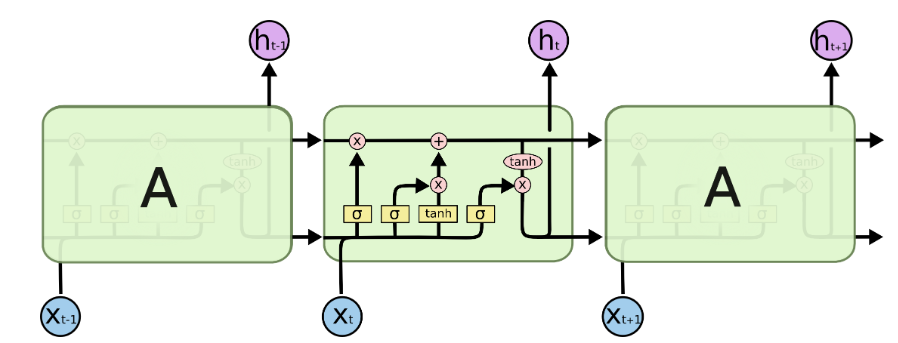

-Obtener la exactitud del modelo, separando los datos en el conjunto de entrenamiento y conjunto de prueba.



In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import torch
import torch.nn as nn

In [4]:
def findFiles(path):
    return glob.glob(path)

def unicodeToASCII(s):
    '''Unicode string to ascii string'''
    return ''.join(c for c in unicodedata.normalize('NFD',s)
                  if unicodedata.category(c)!= 'Mn'
                   and c in all_letters)

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToASCII(line) for line in lines]
    


In [5]:
#leemos los datos
category_lines = {}
category_lines_test = {}
all_categories = []
split_size = 0.85

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    split = int(len(lines) * split_size)
    category_lines[category] = lines[0:split]
    category_lines_test[category] = lines[split:-1]
 
all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)
n_categories = len(all_categories)

In [6]:
print(len(category_lines["Spanish"]))
print(len(category_lines_test["Spanish"]))

253
44


In [7]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [8]:
print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


In [9]:
# Aquí se encuentra definida la arquitectura
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def train(self, category_tensor, line_tensor, criterion, learning_rate=0.005):
        hidden = rnn.initHidden()

        rnn.zero_grad()
        for i in range(line_tensor.size()[0]):
            output, hidden = self(line_tensor[i], hidden)
        loss = criterion(output, category_tensor)
        loss.backward()

        for p in self.parameters():
            p.data.add_(-learning_rate, p.grad.data)
        return output, loss.item()

    def predict(self, input_line, n_predictions=3):
        print(f'\n>{input_line}')
        with torch.no_grad():
            output = evaluate(lineToTensor(input_line))

            # get top N categories
            topv, topi = output.topk(n_predictions, 1, True)
            predictions = []
            for i in range(n_predictions):
                value = topv[0][i].item()
                category_index = topi[0][i].item()
                print('(%.2f) %s' % (value, all_categories[category_index]))
                predictions.append([value, all_categories[category_index]])


In [10]:
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample(train=True):
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category] if train else category_lines_test[category])
    category_tensor = torch.tensor(
        [all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


In [11]:
n_hidden = 128
criterion = nn.NLLLoss()
rnn = RNN(n_letters, n_hidden, n_categories)

In [12]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
import time
import math

n_iters = 150000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample(train=True)
    output, loss = rnn.train(category_tensor, line_tensor, criterion, learning_rate=0.005)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else f'✗ ({category})'
    
        porcentage = iter / n_iters * 100
        data = (iter, porcentage, timeSince(start), loss, line, guess, correct)
        print('%d %d%% (%s) %.4f %s is an %s %s' % data)

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 3% (0m 7s) 2.3445 Arlotti is an Italian ✓
10000 6% (0m 15s) 1.8072 Srour is an Arabic ✓
15000 10% (0m 22s) 2.0119 Kennedy is an Irish ✗ (English)
20000 13% (0m 30s) 1.6153 Beaumont is an French ✓
25000 16% (0m 37s) 0.5231 Fedosov is an Russian ✓
30000 20% (0m 44s) 2.4463 Netsch is an Scottish ✗ (Czech)
35000 23% (0m 52s) 0.7527 Kobi is an Japanese ✓
40000 26% (1m 0s) 0.0838 Africani is an Italian ✓
45000 30% (1m 8s) 1.5368 Bruce is an Scottish ✓
50000 33% (1m 14s) 1.7528 Addario is an Portuguese ✗ (Italian)
55000 36% (1m 21s) 1.5711 Kuiper is an German ✗ (Dutch)
60000 40% (1m 27s) 3.5287 Johnston is an English ✗ (Scottish)
65000 43% (1m 34s) 4.5737 Ohalloran is an Irish ✗ (English)
70000 46% (1m 40s) 0.3099 Byon is an Korean ✓
75000 50% (1m 47s) 0.6946 Fujita is an Japanese ✓
80000 53% (1m 54s) 2.1007 Fitchett is an German ✗ (English)
85000 56% (2m 2s) 0.2979 Zhou is an Chinese ✓
90000 60% (2m 9s) 0.5098 Bermudez is an Spanish ✓
95000 63% (2m 16s) 0.7008 Hiu is an Chinese ✓
100000

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

<Figure size 640x480 with 1 Axes>

In [15]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output
    
def see_confusion(training):
    confusion = torch.zeros(n_categories, n_categories)
    correct = 0
    n_confusion = 10000

    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample(train=training)
        output = evaluate(line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1
        
        if category_i == guess_i: correct += 1

    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    print(f"accuracy = {correct / n_confusion}")

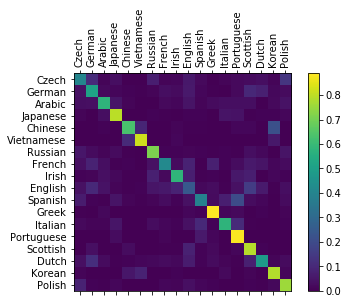

accuracy = 0.6267


In [16]:
see_confusion(training=True)

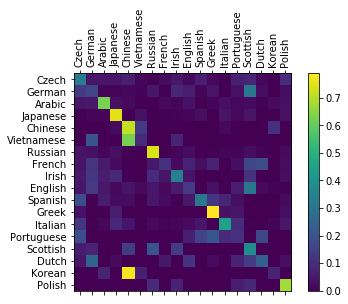

accuracy = 0.3886


In [17]:
see_confusion(training=False)

In [18]:
predict("Zhao")
predict("Alah")
predict("Shiomi")
predict("Connor")
predict("Hernandez")
predict("Voltaire")
predict("Paganni")
predict("Schneider")
predict("Yun")
predict("Sayaka")
predict("Tomoyo")
predict("Alah")
predict("Perez")


NameError: name 'predict' is not defined